<a href="https://colab.research.google.com/github/jounb/PPP/blob/main/Capstone_3_PPP_loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Research Background and Goals**

During the COVID-19 pandemic, PPP Loans have been critical for small businesses to keep their businesses open. While the loans have helped numerous businesses, there has also been controversy around large loan amounts going to bigger companies rather than the intended small businesses.

In this study, approved PPP loan data will be analyzed to answer the following questions:

1.   What is the breakdown of loans by loan amount and industry?
2.   How much relief is going to support larger payroll costs vs. smaller?)
3.   Are there any differences in loan amounts based on reported gender?

The findings from this analysis can benefit government leaders to understand the distribution of PPP loans, and if there are any recommendations that can be implemented to future relief programs to make it more equitable.

# **2. Data Overview and Wrangling**

The Small Business Administration has published PPP approved loan amounts by business and limited demographic information on sba.gov 

There are 9 csv files that are a total of 3 GB of data and 7,341,398 rows.  Due to size, files will be uploaded as public AWS S3 objects, and then pulled in and merged into one data frame to be analyzed.

Additionally, the available dataset has NAICS codes for industries, so a look-up table will be joined to convert NAICS codes to industry descriptions. This will be used to provide a reader-friendly view of breakdown of loans by industry.


First, we'll import all needed packages for this analysis:

In [ ]:
import pandas as pd
import math
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import numpy as np

Then, we'll create dataframes for each of the 9 csv files from sba.gov.

WARNING: the next cell will take ~5 minutes to run.

In [ ]:
df1 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_150k_plus.csv')
df2 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_1.csv')
df3 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_2.csv')
df4 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_3.csv')
df5 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_4.csv')
df6 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_5.csv')
df7 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_6.csv')
df8 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_7.csv')
df9 = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/public_up_to_150k_8.csv')


We'll merge all the data into one dataframe and review the columns 

In [ ]:
ppp_df1 = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

print(ppp_df1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7341398 entries, 0 to 161436
Data columns (total 51 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   LoanNumber                   int64  
 1   DateApproved                 object 
 2   SBAOfficeCode                float64
 3   ProcessingMethod             object 
 4   BorrowerName                 object 
 5   BorrowerAddress              object 
 6   BorrowerCity                 object 
 7   BorrowerState                object 
 8   BorrowerZip                  object 
 9   LoanStatusDate               object 
 10  LoanStatus                   object 
 11  Term                         int64  
 12  SBAGuarantyPercentage        int64  
 13  InitialApprovalAmount        float64
 14  CurrentApprovalAmount        float64
 15  UndisbursedAmount            float64
 16  FranchiseName                object 
 17  ServicingLenderLocationID    float64
 18  ServicingLenderName          object 
 19  S

There are 7,341,398 rows and 51 columns.

Not all columns will be needed, so we'll create a smaller dataframe with needed columns and delete other ones since Google Colab has limited disk & drive space.

In [ ]:
del df1, df2, df3, df4, df5, df6, df7, df8, df9

ppp_df2 = ppp_df1[["LoanNumber", "CurrentApprovalAmount",  "BorrowerState", "Race", "NAICSCode", "Gender", "JobsReported"]]
print(ppp_df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7341398 entries, 0 to 161436
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   LoanNumber             int64  
 1   CurrentApprovalAmount  float64
 2   BorrowerState          object 
 3   Race                   object 
 4   NAICSCode              float64
 5   Gender                 object 
 6   JobsReported           float64
dtypes: float64(3), int64(1), object(3)
memory usage: 448.1+ MB
None


Now that we have this df cleaned up, let's join the NAICS code table  so we can see loan by industry

In [ ]:
del ppp_df1

NAICS_df = pd.read_csv('https://ppploandataanalysis.s3.us-east-2.amazonaws.com/03-03-21+Paycheck+Protection+Program+Data/6-digit_2017_NAICS.csv')

NAICS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   2017 NAICS Code   1057 non-null   int64 
 1   2017 NAICS Title  1057 non-null   object
 2   Summary_NAICS     1057 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.9+ KB


We'll merge the the dataframes based on NAICS code

In [ ]:
ppp_df3 = pd.merge(left = ppp_df2, right = NAICS_df, how = "left", left_on= ["NAICSCode"], right_on= ["2017 NAICS Code"])

ppp_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7341398 entries, 0 to 7341397
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   LoanNumber             int64  
 1   CurrentApprovalAmount  float64
 2   BorrowerState          object 
 3   Race                   object 
 4   NAICSCode              float64
 5   Gender                 object 
 6   JobsReported           float64
 7   2017 NAICS Code        float64
 8   2017 NAICS Title       object 
 9   Summary_NAICS          object 
dtypes: float64(4), int64(1), object(5)
memory usage: 616.1+ MB


We only need the summary_naics colummn, so we'll remove the code and titles. We'll also check for NAs again

In [ ]:
del ppp_df2

ppp_df3 = ppp_df3.drop(columns= ['2017 NAICS Code', '2017 NAICS Title'])

ppp_df3.isna().sum()

LoanNumber                    0
CurrentApprovalAmount         0
BorrowerState               166
Race                          0
NAICSCode                132795
Gender                        0
JobsReported                  6
Summary_NAICS            227699
dtype: int64

Lastly, we'll clean up any data where ppp loan amount is less than $1 and JobsReported are 0 or less.

In [ ]:
ppp_df = ppp_df3.dropna()

clean = (ppp_df['JobsReported'] >= 1) & (ppp_df['CurrentApprovalAmount'] > 1)

ppp_df= ppp_df.iloc[clean.values]

ppp_df['JobsReported'].describe()

count    7.113346e+06
mean     1.073093e+01
std      2.969753e+01
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      5.000000e+02
Name: JobsReported, dtype: float64

In [ ]:
del ppp_df3

# **3. Data Analysis and Insights**

Now that we have all our data, we'll look at metrics regarding dependent variable (loan amount) and how PPP loans have been distributed.

Our first question to explore is:
* What is the breakdown of loans by loan amount and industry?




In [ ]:
ppp_df['CurrentApprovalAmount'].describe()

count    7.113346e+06
mean     9.390351e+04
std      3.117902e+05
min      1.050000e+00
25%      1.078500e+04
50%      2.091544e+04
75%      6.698700e+04
max      1.000000e+07
Name: CurrentApprovalAmount, dtype: float64

In order to see the breakdown of loans by loan amount, we'll group the loan amounts based on buckets so we can visualize them.

In [ ]:
def loanbucket (x):
  if x < 10000:
    return "0-10k"
  elif x < 100000:
    return "10-99k"
  elif x < 500000:
    return "100-499k"
  elif x < 1000000:
    return "500-999k"
  else:
    return ">1M"


In [ ]:
ppp_df['loan_amt_bucket'] = ppp_df.CurrentApprovalAmount.apply(loanbucket)


ppp_df.loan_amt_bucket.value_counts()

10-99k      4203667
0-10k       1628527
100-499k    1039902
500-999k     141730
>1M           99520
Name: loan_amt_bucket, dtype: int64

We'll create a pie chart to show the number of loans distributed by loan amount

In [ ]:
loansum = ppp_df.groupby('loan_amt_bucket')['CurrentApprovalAmount'].sum()
loancount = ppp_df.groupby('loan_amt_bucket')['LoanNumber'].count()

Text(0.5, 1.0, 'Number of Loans by Loan Amount')

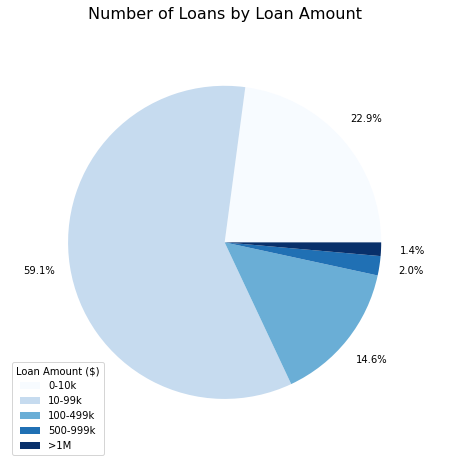

In [ ]:
fontdict = {'fontsize': 16}

loancount.plot.pie(autopct="%.1f%%", labels = None, figsize = (8,8), pctdistance = 1.2, colormap = 'Blues', radius = 0.9)

plt.legend(loc = 'lower left', labels = loancount.index, title = 'Loan Amount ($)')
plt.ylabel('')
plt.title('Number of Loans by Loan Amount' ,fontdict = fontdict )


82% of the loans went to smaller loan amounts (i.e. less than 100k).

Only 1.4% of loans were greater than $1M.

Now, let's look at how the loan $s were distributed based on the same buckets.

Text(0.5, 1.0, 'Loan Volume by Loan Amount')

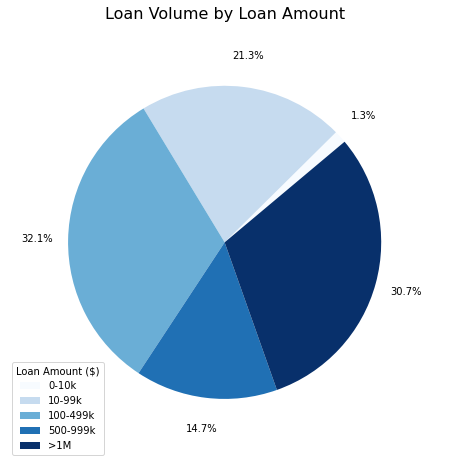

In [ ]:
fontdict = {'fontsize': 16}

loansum.plot.pie(autopct="%.1f%%", labels = None, figsize = (8,8), pctdistance = 1.2, colormap = 'Blues', radius = 0.9, startangle = 40)

plt.legend(loc = 'lower left', labels = loancount.index, title = 'Loan Amount ($)')
plt.ylabel('')
plt.title('Loan Volume by Loan Amount' ,fontdict = fontdict )

A very different picture!

Although only 1.4% of loans were greater than $1M, those loans made up 30.7% of total loan amount. However, this would make sense if the companies with larger loan amounts have more employees. 

In order to normalize loan amount by employee, let's look at the distribution of loan amount per job reported. Note that max PPP loan amount is calculated as 2.5 months of payroll cost, and guidance is given to cap wages up to $100k.

See more details on how max ppp loan amount is calculated: https://www.sba.gov/sites/default/files/2021-03/HowtoCalculateFirstDrawLoanAmountsFAQs-3.12.21-508.pdf

Since PPP loans cover 2.5 months of payroll, we'll create a new column that annualizes the loan amount so that it is easier to digest (i.e. divide by 2.5 and then multiply by 12)



In [ ]:
ppp_df['payroll'] = (ppp_df['CurrentApprovalAmount'] / ppp_df['JobsReported']) / 2.5 * 12

ppp_df['payroll'].describe()



count    7.113346e+06
mean     4.654242e+04
std      4.786441e+04
min      1.478400e+00
25%      2.143104e+04
50%      3.860571e+04
75%      6.408480e+04
max      3.126239e+07
Name: payroll, dtype: float64

The average payroll (or loan per job) is 40k which is in line with the national avg income of $34k (source: https://www.census.gov/quickfacts/fact/table/US/INC910219)

Now let's bucket this metric so we can easily visualize the distribution.

In [ ]:
def bucket (x):
  if x < 40000:
    return "0-39k"
  elif x < 80000:
    return "40-79k"
  elif x < 100000:
    return "80-99k"
  else:
    return ">100k"



In [ ]:
ppp_df['payroll_bucket'] = ppp_df['payroll'].apply(bucket)

ppp_df.payroll_bucket.value_counts()


0-39k     3680625
40-79k    2259581
80-99k     924439
>100k      248701
Name: payroll_bucket, dtype: int64

Similar to the earlier pie charts on ppp loans and loan amounts, we'll look at the same visualizations for loan per job supported.

In [ ]:
payroll_sum = ppp_df.groupby('payroll_bucket')['CurrentApprovalAmount'].sum()
payroll_ct = ppp_df.groupby('payroll_bucket')['LoanNumber'].count()

Text(0.5, 1.0, 'Loan Count by Payroll')

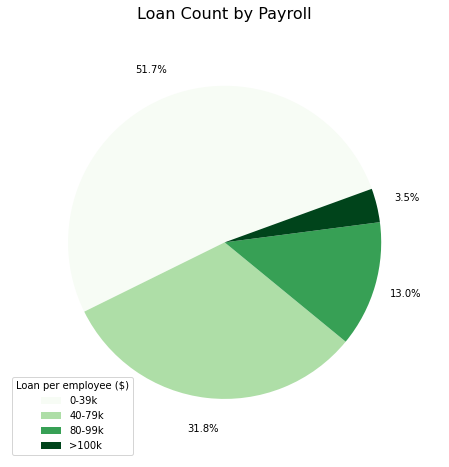

In [ ]:
fontdict = {'fontsize': 16}

payroll_ct.plot.pie(autopct="%.1f%%", labels = None, figsize = (8,8), pctdistance = 1.2, colormap = 'Greens', radius = 0.9, startangle = 20)

plt.legend(loc = 'lower left', labels = payroll_ct.index, title = 'Loan per employee ($)')
plt.ylabel('')
plt.title('Loan Count by Payroll' ,fontdict = fontdict )

Text(0.5, 1.0, 'Loan Volume by Payroll')

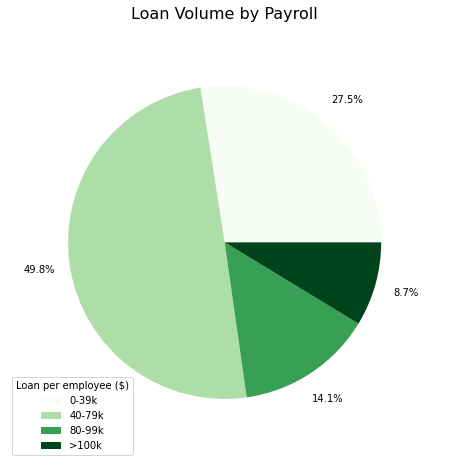

In [ ]:
fontdict = {'fontsize': 16}

payroll_sum.plot.pie(autopct="%.1f%%", labels = None, figsize = (8,8), pctdistance = 1.2, colormap = 'Greens', radius = 0.9)

plt.legend(loc = 'lower left', labels = payroll_sum.index, title = 'Loan per employee ($)')
plt.ylabel('')
plt.title('Loan Volume by Payroll' ,fontdict = fontdict )

Let's check the value counts where payroll was greater than **100k**

In [ ]:
def payroll_morethan100k (x):
  if x < 100000:
    return "0-100k"
  if x < 200000:
    return "100-200k"
  elif x < 500000:
    return "200-500k"
  else:
    return ">500k"

In [ ]:
ppp_df['greaterthan100k'] = ppp_df['payroll'].apply(payroll_morethan100k)
ppp_df['greaterthan100k'].value_counts()

0-100k      6864645
100-200k     231188
200-500k      15404
>500k          2109
Name: greaterthan100k, dtype: int64

In [ ]:
ppp_df.groupby('greaterthan100k')['CurrentApprovalAmount'].sum()

greaterthan100k
0-100k      6.099201e+11
100-200k    5.297432e+10
200-500k    3.792004e+09
>500k       1.281711e+09
Name: CurrentApprovalAmount, dtype: float64

Currently PPP loan application guidance is to cap wages up to $100k. However, the loan amount per job is showing that a significant amount of loans is going to cover payroll costs that are >100k. 17.4k loans or 5.1 billion dollars went to companies with payroll costs greater than 200k!


In order to optimize the reach of relief, the loan per job supported capped and enforced at 100k. Additionally, for loans that supported payroll costs of >200k, there should be an audit to determine misuse of funds, or data issues.

Finally, let's look at loan count by industry.

Text(0.0, 1.0, 'Loan Count by Industry')

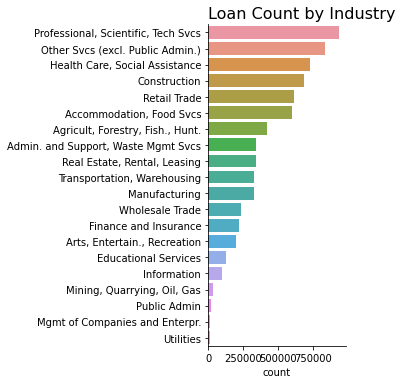

In [ ]:
#loan count by industry

fontdict = {'fontsize': 16}
sns.catplot(y= "Summary_NAICS", kind = 'count', data = ppp_df, order = ppp_df.Summary_NAICS.value_counts().index)
plt.ylabel('')
plt.title('Loan Count by Industry', fontdict= fontdict, loc = 'left',)

Surprisingly, retail trade is the 5th highest industry.

Now that we have a baseline understanding of how loans were distributed, let's look at loan demographics and if there are any differences in mean loan amount by gender.


# **4. Hypothesis testing - Mean loan amount by Gender**

The first hypothesis we'll test is mean loan amount by gender:

$H_0: \mu_1 = \mu_2$

The mean loan amount is equal for male owned businesses vs. female owned businesses

$H_1: \mu_1 \neq \mu_2$

H1: µ1 ≠ µ2 : The mean loan amount is not equal for male owned businesses vs. female owned businesses


First, let's look at what values are available for testing in the Gender column

In [ ]:
ppp_df.Gender.value_counts()

Unanswered      4826524
Male Owned      1652269
Female Owned     634553
Name: Gender, dtype: int64

The majority of applicants chose to not disclose their gender.

Next we'll look at how the loan amount is distributed

Text(0.5, 1.0, 'Distribution of CurrentApprovalAmount')

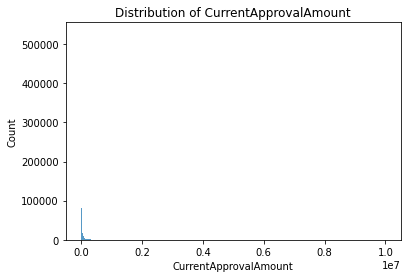

In [ ]:
sns.histplot(ppp_df, x = 'CurrentApprovalAmount')
plt.title('Distribution of CurrentApprovalAmount')

Since the loan amount distribution is very broadly distributed and not normal, we'll normalize the distribution by log transforming the data.

Text(0.5, 1.0, 'Distribution of Log Transformed CurrentApprovalAmount')

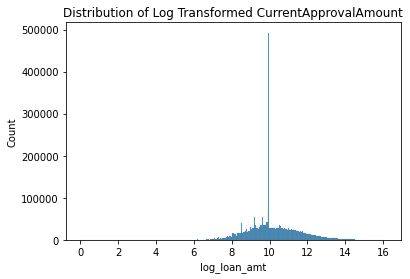

In [ ]:
ppp_df['log_loan_amt'] = np.log ( ppp_df['CurrentApprovalAmount'] )

sns.histplot(data = ppp_df, x = 'log_loan_amt')
plt.title('Distribution of Log Transformed CurrentApprovalAmount')

The data looks more normal now to perform hypothesis testing. We'll create a dataframe for males and females.

In [ ]:
mppp_df = ppp_df.iloc[(ppp_df['Gender'] == 'Male Owned').values]
fppp_df = ppp_df.iloc[(ppp_df['Gender'] == 'Female Owned').values]


In [ ]:
stats.ttest_ind(mppp_df['log_loan_amt'], fppp_df['log_loan_amt'])

Ttest_indResult(statistic=214.35217523791445, pvalue=0.0)

For log transformed data, typically data is transformed back to the original scale as geometric means, which is a good estimate of the original median.

Geometoric means are the anti-logs of the mean of the logged data. Additionally a property of logarithims is that "the difference between logs is the log of the ratio".

Thus, when we take the difference in mean log amounts and take the anti log, this translates to the "ratio of geometric mean amount of male loan amounts to female loan amounts."

This article was used to handle ttests and CIs for log transforned data: http://www.jerrydallal.com/LHSP/ci_logs.htm




In [ ]:
math.exp(mppp_df['log_loan_amt'].mean()- fppp_df['log_loan_amt'].mean())


1.5471511245889853

Based on the article above, you can say that the median loan amount for men is approximately 1.547 of the median loan amount for women.

Now let's calculate the confidence interval. The confidence interval will be the ratio of the medians in the original scale.

We'll create confidence intervals using a defined function that returns the anti logs of the lower and upper CIs

In [ ]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    ci_lower_antilog = math.exp(ci_lower)
    ci_upper_antilog = math.exp(ci_upper)
    return ci_lower_antilog, ci_upper_antilog

In [ ]:
get_95_ci(fppp_df['log_loan_amt'], mppp_df['log_loan_amt'])


(1.541104522144651, 1.5532214511873885)

We can say that the median loan amount for males is approximately 1.547 of women (95% confidence level with CI of 1.541 to 1.553)

The median loan amount for men is significnatly higher. This could be due a higher ratio of larger companies owned by men. What if we adjust by company size? 

This brings us to our next hypothesis testing:



# **5. Hypothesis testing - Mean loan amount by gender, adjusted by company size**

$H_1: \mu_1 = \mu_2$

The mean loan amount is equal for male owned businesses that are small/medium/large vs. female owned businesses of the same size

$H_1: \mu_1 \neq \mu_2$

The mean loan amount is not equal for male owned businesses that are small/medium/large vs. female owned businesses of the same size

See below function for how we'll define small, medium, and large.



In [ ]:
def companysize (x):
  if x < 10:
    return "Small (0-9)"
  elif x < 100:
    return "Mid (10-99)"
  else:
    return "Large (100-500)"



In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

ppp_df['company_size'] = ppp_df.JobsReported.apply(companysize)
mppp_df['company_size'] = ppp_df.JobsReported.apply(companysize)
fppp_df['company_size'] = ppp_df.JobsReported.apply(companysize)


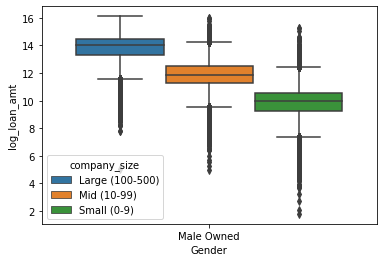

In [ ]:
sns.boxplot(data = mppp_df, x = 'Gender', y = 'log_loan_amt', hue = 'company_size')

Now we see that the difference in logged mean loan amounts by gender looks similar. 

Let's test gender difference for large companies:

In [ ]:
m_large = mppp_df.iloc[(mppp_df.company_size == 'Large (100-500)').values]
f_large = fppp_df.iloc[(fppp_df.company_size == 'Large (100-500)').values]

print(m_large.CurrentApprovalAmount.mean())
print(f_large.CurrentApprovalAmount.mean())

1522447.9641778392
1228967.0700018161


In [ ]:
stats.ttest_ind(m_large['log_loan_amt'], f_large['log_loan_amt'])

Ttest_indResult(statistic=16.344133583417506, pvalue=8.322378847347348e-60)

In [ ]:
math.exp(m_large['log_loan_amt'].mean()- f_large['log_loan_amt'].mean())

1.2977064995354546

In [ ]:
get_95_ci(f_large['log_loan_amt'], m_large['log_loan_amt'])

(1.255838651779454, 1.3409701608963607)

The median loan amount for male owners of large companies is approximately 1.298 of women (95% confidence level with CI of 1.256 to 1.341)

Let's do the same for mid and small companies:

In [ ]:
m_mid = mppp_df.iloc[(mppp_df.JobsReported == 100).values]
f_mid = fppp_df.iloc[(fppp_df.JobsReported == 100).values]

print(stats.ttest_ind(m_mid['log_loan_amt'], f_mid['log_loan_amt']))
print(math.exp(m_mid['log_loan_amt'].mean()- f_mid['log_loan_amt'].mean()))
print(get_95_ci(f_mid['log_loan_amt'], m_mid['log_loan_amt']))

Ttest_indResult(statistic=3.965270176280296, pvalue=7.815277837997429e-05)
1.5017930298743898
(1.2066780635428727, 1.8690837040306958)


The median loan amount for male owners of mid-size companies is approximately 1.502 of women (95% confidence level with CI of 1.207 to 1.869)

In [ ]:
m_small = mppp_df.iloc[(mppp_df.company_size == 'Small (0-9)').values]
f_small = fppp_df.iloc[(fppp_df.company_size == 'Small (0-9)').values]

print(stats.ttest_ind(m_small['log_loan_amt'], f_small['log_loan_amt']))
print(math.exp(m_small['log_loan_amt'].mean()- f_small['log_loan_amt'].mean()))
print(get_95_ci(f_small['log_loan_amt'], m_small['log_loan_amt']))

Ttest_indResult(statistic=159.6462514226609, pvalue=0.0)
1.310588078975215
(1.306201866532768, 1.3149890202739611)


The median loan amount for male owners of small companies is approximately 1.311 of women (95% confidence level with CI of 1.306 to 1.315)


At every level of company size, the avg loan amount for females is lower at a significant level!

# **6. Hypothesis testing - % of PPP loans to women owned businesses vs. total US proportion**

Lastly, let's look at % of ppp loans that went to female owned businesses vs. % of women-owned businesses in US population.

Per the American Express 2019 study, 37% of US firms were owned by women. 

https://s1.q4cdn.com/692158879/files/doc_library/file/2019-state-of-women-owned-businesses-report.pdf


$H_1: \mu_1 = \mu_2$

The % of ppp loans to female owned businesses is equal to the total % of businesses owned by women.

$H_1: \mu_1 \neq \mu_2$

The % of ppp loans to female owned businesses is not equal to the total % of businesses owned by women.




First let's get the % of ppp loans that went to women owned businesses.

In [ ]:
f_prop = fppp_df.shape[0] / (fppp_df.shape[0] + mppp_df.shape[0])

28% of PPP loans went to women owned businesses, even though 37% of businesses are owned by women. Let's perform a one sample z test to determine statistical significance.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

fem_count = fppp_df.shape[0]
total_count = (fppp_df.shape[0] + mppp_df.shape[0])
proportions_ztest(count= fem_count, nobs = total_count, value = 0.37)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(-312.4627702147293, 0.0)

In [ ]:
std_err = math.sqrt((f_prop*(1-f_prop))/total_count)

margin_of_error = 1.96 * std_err

print(f_prop, " +/- ",margin_of_error)

0.2774824625615811  +/-  0.000580339133698025


At a p-value of <0.01, the proportion of women who received a PPP loan is significantly smaller than the proportion of women owned businesses in the US.

# **7. Findings and Recommendations**

Through this analysis, we have the following findings:


Loan Distribution Findings: 
*   Although only 1.4% of loans were greater than 1M USD, those loans made up 30.7% of total loan amount. 
*   When normalizing loan amount by employee, 9% of loans went to support 
businesses where the annualized loan amount per employee was +100k, even though the current PPP loan application guidance is to cap wages up to 100k. 
*   17.5k loans went to comopanies wtih payroll costs >200k, equating to 5.1B dollars

For women-owned business, we found that:
* The mean loan amount for women owned businesses were significantly lower than male owned businesses, even when adjusting for company sizee
* Only 28% of ppp loans went to women owned businesses, when 37% of firms are owned by women.
* **Caveat:** Majority (68%) of applicants did not disclose gender, potentially misleading results. E.g. One gender could be more or less likely to disclose their gender, thus skewing the data

Recommendations:
* In order to optimize the reach of relief, cap and enforce the loan amount per employee to 100k
* Additionally, for outlier loans that were >200k/job supported, look into misuse of funds, or data issues.
* Further analysis on wny the mean loan amount for women owned businesses are lower than male counterparts
* Potential outreach and education for women owned businesses on future relief programs